# Generative Models PHW4: Normalizing Flows

Name: Ali Ghasemzadeh

Student ID: 401106339

## Setup

In [1]:
# Import necessary libraries
import os
import random
import numpy as np
from tqdm import trange
import imageio.v2 as imageio
from matplotlib import pyplot as plt
from typing import Callable, Optional, Tuple, Union, List
from IPython.display import Image, display

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
from torch.utils.data import DataLoader, TensorDataset


from sklearn.datasets import make_moons, make_circles
from tqdm import tqdm

In [2]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cuda device


In [3]:
device = 'cpu'

In [133]:
# @title visualization helpers

def visualize(flow, epoch, output_dir='frames', device='cpu'):
    # Create directory for saving frames
    os.makedirs(output_dir, exist_ok=True)

    # Visualization of the learned density
    with torch.no_grad():
        # Create a grid over the range of the data
        xline = torch.linspace(-2, 3, 300, device=device)
        yline = torch.linspace(-1, 1.5, 300, device=device)
        xgrid, ygrid = torch.meshgrid(xline, yline, indexing='ij')
        xyinput = torch.cat([xgrid.reshape(-1, 1),
                             ygrid.reshape(-1, 1)], dim=1).to(device)

        # Compute the log probability for each point in the grid
        log_prob_grid = flow.log_prob(xyinput)  # Compute log probs
        zgrid = torch.exp(log_prob_grid).reshape(300, 300).cpu()  # Convert to probability

        # Plot the density
        plt.figure(figsize=(8, 6))
        plt.contourf(
            xgrid.cpu().numpy(),
            ygrid.cpu().numpy(),
            zgrid.numpy(),
            levels=50,
            cmap='viridis'
        )
        plt.title(f'Learned Density at Epoch {epoch}')
        plt.xlabel(r'$x_1$')
        plt.ylabel(r'$x_2$')
        plt.colorbar(label='Density')

        # Save frame as an image
        filename = os.path.join(output_dir, f'frame_{epoch:03d}.png')
        plt.savefig(filename)
        plt.close()

def create_gif(output_dir='frames', gif_name='density_evolution.gif', fps=10):
    images = []
    for frame in sorted(os.listdir(output_dir)):
        if frame.endswith(".png"):
            images.append(imageio.imread(os.path.join(output_dir, frame)))
    imageio.mimsave(gif_name, images, fps=fps)
    display(Image(filename=gif_name))
    return gif_name

# Dataset (5 points)

Create moons using the `make_moons` dataset from `sklearn.datasets`. You must use `TensorDataset` to create a `DataLoader` for this dataset.

In [134]:
# Generate dataset
X, _ = make_moons(n_samples=10000, noise=0.1, random_state=42)
X = torch.tensor(X, dtype=torch.float32)

# DataLoader
dataset = TensorDataset(X)
data_loader = DataLoader(dataset, batch_size=256, shuffle=True)

In [135]:
for x in data_loader:
    print(x[0].shape)
    break

torch.Size([256, 2])


# Transformations (30 points)

One of the challenges in creating flow models is creating invertible transformations. Also we would like it if computation of their inverse and/or the log determinant of their jacobian were simple.

In [136]:
class Transform(nn.Module):
    """Base class for all transform objects."""

    def forward(self, inputs, context=None):
        raise NotImplementedError()

    def inverse(self, inputs, context=None):
        raise 'InverseNotAvailable'

First we can create a random permutation transform.

In [149]:
class PermutationTransform(Transform):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features
        permutation = torch.randperm(num_features)
        self.register_buffer('permutation', permutation)
        self.register_buffer('inverse_permutation', torch.argsort(permutation))

    def forward(self, inputs, context=None):
        return inputs[:, self.permutation], 0  # Log-det is zero

    def inverse(self, inputs, context=None):
        return inputs[:, self.inverse_permutation]

Now you must:

1. **Scaling and Translation Networks**:
	- Use `self.s_net_factory` and `self.t_net_factory` to initialize the scaling (`s`) and translation (`t`) networks in the `__init__` method.

2. **Forward Pass**:
	-	Pass fixed_inputs through `self.scaling_net` and `self.translation_net` to compute `s` and `t`.

	-	Apply the transformations to `transformed_inputs`.

  - Compute the log-determinant of the Jacobian.

3. **Inverse Pass**:
	-	Solve for `transformed_inputs` by reversing the scaling and translation.

4. **Utility Method **`_initialize_network`:
	-	Use `nn.Sequential`to create a feedforward neural network with the desired hidden dimensions and activation functions.

In [150]:
class CouplingTransform(Transform):
    """
    Implements a coupling layer for a normalizing flow model.
    It splits the input features into two groups based on a binary mask.
    One group remains unchanged while the other is transformed.
    """

    def __init__(
        self,
        mask: Union[torch.Tensor, list, tuple],
        hidden_dims: int,
        s_net_factory: Optional[Callable[[int, int, int], nn.Module]] = None,
        t_net_factory: Optional[Callable[[int, int, int], nn.Module]] = None,
    ):
        """
        Args:
            mask (Union[torch.Tensor, list, tuple]): Binary mask specifying which features to transform.
                * If `mask[i] > 0`, `input[i]` will be transformed.
                * If `mask[i] <= 0`, `input[i]` will remain unchanged.
            hidden_dims (int): Number of hidden units for the coupling neural networks.
            s_net_factory (Callable): Function to create a neural network for the scaling function.
                Must take (input_dim, output_dim, hidden_dims) as arguments.
            t_net_factory (Callable): Function to create a neural network for the translation function.
                Must take (input_dim, output_dim, hidden_dims) as arguments.
        """
        super().__init__()

        # Validate and register the binary mask
        mask = torch.as_tensor(mask, dtype=torch.float32)
        if mask.dim() != 1:
            raise ValueError("Mask must be a 1-dimensional tensor.")
        if mask.numel() == 0:
            raise ValueError("Mask cannot be empty.")
        self.register_buffer('mask', mask)

        # Number of input features
        self.num_features = mask.numel()
        self.mask = nn.Parameter(mask, requires_grad=False)
        # Validate and store the network factories
        if not callable(s_net_factory) or not callable(t_net_factory):
            raise ValueError("s_net_factory and t_net_factory must be callable functions.")
        # self.s_net_factory = s_net_factory
        # self.t_net_factory = t_net_factory

        # Initialize the scaling (s) and translation (t) networks
        # These will be defined using the factories in the TODO section
        self.s_net = self._initialize_network(self.num_features, self.num_features, hidden_dims)
        self.t_net = self._initialize_network(self.num_features, self.num_features, hidden_dims)

        # TODO: Define the networks (see instructions below)

    def _initialize_network(
        self, input_dim: int, output_dim: int, hidden_dims: int
    ) -> nn.Module:
        """
        Utility method to create a neural network.

        Args:
            input_dim (int): Number of input features for the network.
            output_dim (int): Number of output features for the network.
            hidden_dims (int): Number of hidden units for the network.

        Returns:
            nn.Module: A PyTorch neural network.
        """
        # TODO: Use this function to initialize scaling and translation networks.
        return nn.Sequential(
            nn.Linear(input_dim, hidden_dims),
            nn.LeakyReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.LeakyReLU(),
            nn.Linear(hidden_dims, output_dim),
        )

    def forward(self, inputs: torch.Tensor, context: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through the coupling transform.

        Args:
            inputs (torch.Tensor): Input tensor of shape (batch_size, num_features).
            context (Optional[torch.Tensor]): Optional context for conditional transformations.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]:
                - Transformed inputs of the same shape as the input.
                - Log-determinant of the Jacobian of the transformation.
        """
        # Validate input dimensions
        if inputs.dim() != 2:
            raise ValueError("Inputs must be a 2D tensor.")
        if inputs.shape[1] != self.num_features:
            raise ValueError(f"Expected {self.num_features} features, but got {inputs.shape[1]}.")

        # Split inputs into fixed and transformed groups based on the mask
        z = inputs
        z_ = self.mask * z
        # TODO: Compute scaling (s) and translation (t) using the neural networks
        # Use the fixed_inputs as input to the networks
        s = torch.tanh(self.s_net(z_))*(1-self.mask)
        t = self.t_net(z_)*(1-self.mask)
        # Scale transformed_inputs by exp(s) and shift by t
        scaled_data = (1 - self.mask) * (z - t) * torch.exp(-s)
        # Optionally: Use tanh or clamp to keep scaling factors bounded
        z = z_ + scaled_data  # Combine fixed_inputs and transformed_inputs to form the output
        log_det_J = -s.sum(dim=1)  # Compute the log-determinant of the Jacobian

        return z, log_det_J

    def inverse(self, inputs: torch.Tensor, context: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Inverse pass through the coupling transform.

        Args:
            inputs (torch.Tensor): Input tensor of shape (batch_size, num_features).
            context (Optional[torch.Tensor]): Optional context for conditional transformations.

        Returns:
            torch.Tensor: Reconstructed inputs of the same shape as the input.
        """
        # Validate input dimensions
        if inputs.dim() != 2:
            raise ValueError("Inputs must be a 2D tensor.")
        if inputs.shape[1] != self.num_features:
            raise ValueError(f"Expected {self.num_features} features, but got {inputs.shape[1]}.")

        # TODO: Similar to the forward pass, but solve for transformed_inputs
        x = inputs
        x_ = x * self.mask
        s = self.s_net(x_)*(1 - self.mask)
        t = self.t_net(x_)*(1 - self.mask)
        x = x_ + (1 - self.mask) * (x * torch.exp(s) + t)

        # Reverse the scaling and translation operations to reconstruct the input

        return x

# Flows (30 points)

You must:

1.	Forward Pass:
	-	Initialize `log_det_J` to 0.
	-	Iterate over `self.transforms` and apply each transform's forward method.

2.	Inverse Pass:
	-	Iterate through `self.transforms` in reverse order and apply each transform's inverse method.
  - Return the final reconstructed input tensor.

3.	Log-Probability:
	-	Use the forward method to get `z` and `log_det_J`.
	- Compute `log_prob_z` using the base distribution's `log_prob` method.
  - Return `log_prob_z + log_det_J`.

4.	Sampling:
	-	Sample z from the base distribution using `self.base_distribution.sample((num_samples,))`.
	-	Map `z` back to the data space using the inverse method.
	-	Return the generated samples.

5.	Sampling and Log-Probability:
	-	Use the sample method to generate samples.
	-	Use the `log_prob` method to compute log-probabilities for the generated samples.
	-	Return both the samples and their log-probabilities.

In [151]:
class Flow(nn.Module):
    """
    Flow-based model that combines a series of invertible transformations
    with a base distribution for density estimation and sampling.
    """

    def __init__(
        self,
        transforms: List[nn.Module],
        base_distribution: Optional[MultivariateNormal] = None
    ):
        """
        Args:
            transforms (List[nn.Module]): List of invertible transformations (e.g., coupling layers).
            base_distribution (Optional[MultivariateNormal]): The base distribution.
                If None, defaults to a standard multivariate Gaussian.
        """
        super().__init__()
        self.transforms = nn.ModuleList(transforms)
        self.num_features = self.transforms[0].num_features  # Ensure all transforms share the same input size

        if base_distribution is None:
            self.base_distribution = MultivariateNormal(
                loc=torch.zeros(self.num_features),
                covariance_matrix=torch.eye(self.num_features)
            )
        else:
            self.base_distribution = base_distribution

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through the flow model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, num_features).

        Returns:
            Tuple[torch.Tensor, torch.Tensor]:
                - Transformed tensor (latent representation) of the same shape as input.
                - Log-determinant of the Jacobian of the entire transformation.
        """
        # TODO: Implement the forward pass
        # 1. Initialize `log_det_J = 0` to accumulate log-determinants of Jacobians.
        # 2. Iterate through `self.transforms` in order and apply each transform's `forward` method.
        # 3. Update `log_det_J` with the log-determinant of each transform's Jacobian.
        # 4. Return the final transformed tensor and accumulated log-determinant.
        z = x
        log_det_J = x.new_zeros(x.shape[0])
        for transform in reversed(self.transforms):
            z, log_det = transform(z)
            log_det_J += log_det

        return z, log_det_J

    def inverse(self, z: torch.Tensor) -> torch.Tensor:
        """
        Inverse pass through the flow model.

        Args:
            z (torch.Tensor): Latent tensor of shape (batch_size, num_features).

        Returns:
            torch.Tensor: Reconstructed input tensor of the same shape as input.
        """
        # TODO: Implement the inverse pass
        # 1. Iterate through `self.transforms` in reverse order and apply each transform's `inverse` method.
        # 2. Pass `z` sequentially through the inverses of the transforms.
        # 3. Return the final reconstructed input tensor.

        x = z
        for transform in self.transforms:
            x = transform.inverse(x)

        return x

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the log-probability of the input under the flow model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, num_features).

        Returns:
            torch.Tensor: Log-probabilities of the input under the model.
        """
        # TODO: Implement log-probability computation
        # 1. Apply the forward pass to get `z` (latent representation) and `log_det_J`.
        # 2. Compute `log_prob_z` using `self.base_distribution.log_prob(z)`.
        # 3. Return the sum of `log_prob_z` and `log_det_J`.

        z, log_det_J = self.forward(x)
        log_prob_z = self.base_distribution.log_prob(z)
        log_prob = log_prob_z + log_det_J

        return log_prob

    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Generate samples from the flow model.

        Args:
            num_samples (int): Number of samples to generate.

        Returns:
            torch.Tensor: Samples of shape (num_samples, num_features).
        """
        # TODO: Implement sampling
        # 1. Sample from the base distribution to get `z`.
        # 2. Apply the inverse pass to map `z` back to the data space.
        # 3. Return the generated samples.

        z = self.base_distribution.sample((num_samples,))
        x = self.inverse(z)

        return x

    def sample_and_log_prob(self, num_samples: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Generate samples and their log-probabilities under the flow model.

        Args:
            num_samples (int): Number of samples to generate.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]:
                - Samples of shape (num_samples, num_features).
                - Log-probabilities of the samples under the model.
        """
        # TODO: Implement sample and log-prob computation
        # 1. Use `sample` method to generate samples.
        # 2. Use `log_prob` method to compute the log-probabilities of the samples.
        # 3. Return both the samples and their log-probabilities.

        x = self.sample(num_samples)
        log_prob = self.log_prob(x)

        return x, log_prob

# Masks (10 points)

Now you should:

1.	Generate the Masks:
	-	Loop through num_masks and alternate between masks starting with 0 or 1.

2.	Output Requirements:
	-	Ensure the output is a list of `torch.Tensor` objects.
	-	Each tensor should be of shape `(num_features,)` and should alternate patterns as described.

In [152]:
def create_alternating_masks(num_features: int, num_masks: int) -> List[torch.Tensor]:
    """
    Creates a sequence of alternating binary masks for coupling layers in normalizing flows.

    Args:
        num_features (int): The number of features in the input.
        num_masks (int): The number of masks to generate.

    Returns:
        List[torch.Tensor]: A list of binary masks. Each mask is a 1D tensor of size `num_features`.
                            Alternates between masks starting with 0s and masks starting with 1s.
    """
    masks = []
    # TODO:
    # 1. Loop over `range(num_masks)` to create the required number of masks.
    # 2. For each mask index `i`:
    #     - Alternate between starting with 0s (when `i % 2 == 0`) and starting with 1s (when `i % 2 == 1`).
    #     - For example, if `num_features=6`, the masks might look like:
    #       [0, 1, 0, 1, 0, 1], [1, 0, 1, 0, 1, 0], ...
    # 3. Convert the mask into a `torch.Tensor` and append it to the `masks` list.
    # 4. Ensure each mask is of shape `(num_features,)`.
    for i in range(num_masks):
        masks.append(torch.tensor([(i + j) % 2 for j in range(num_features)], dtype=torch.float32))
    masks = torch.from_numpy(np.array(masks).astype(np.float32))
    return masks

# Training (10 points)

Define the model and it's hyperparameters.

In [168]:
# TODO: Create masks and flow
from torch.optim.lr_scheduler import StepLR
num_features = X.shape[1]
num_masks = 3
hidden_dims = 256
masks = create_alternating_masks(num_features, num_masks)

transforms = []
for mask in masks:
    # TODO
    transforms.append(CouplingTransform(
        mask=mask,
        hidden_dims=hidden_dims,
        s_net_factory=lambda input_dim, output_dim, hidden_dims: nn.Sequential(
            nn.Linear(input_dim, hidden_dims),
            nn.LeakyReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.LeakyReLU(),
            nn.Linear(hidden_dims, output_dim),
            nn.Tanh()
        ),
        t_net_factory=lambda input_dim, output_dim, hidden_dims: nn.Sequential(
            nn.Linear(input_dim, hidden_dims),
            nn.LeakyReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.LeakyReLU(),
            nn.Linear(hidden_dims, output_dim),
        ),
    ))

flow = Flow(transforms=transforms)

optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.8)


Now train the model. Make sure you run `visualize(flow, epoch)` at each epoch. (If you don't do this you won't be able to visualize the evolution of your model)

In [169]:
# # TODO: Train the model
num_epochs = 150
losses = []
output_dir = 'frames'
for epoch in range(1, num_epochs + 1):
    epoch_loss = 0
    # X, _ = make_moons(n_samples=2048, noise=0.1)
    # X = torch.tensor(X, dtype=torch.float32)
    # dataset = TensorDataset(X)
    # data_loader = DataLoader(dataset, batch_size=1024)
    
    with tqdm(data_loader, desc=f"Epoch {epoch}/{num_epochs}") as pbar:
        for batch in pbar:
            x_batch, = batch
            log_prob = flow.log_prob(x_batch)
            loss = -log_prob.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_postfix({'loss : ' : loss.item(), 'lr : ' : scheduler.get_last_lr()[0]})
            losses.append(loss.item())
    # if epoch % 100 == 0:
    #     print("loss : ", loss.item())
    # scheduler.step()
      
    visualize(flow, epoch, device=device)

Epoch 150/150: 100%|██████████| 40/40 [00:01<00:00, 20.66it/s, loss : =1.41, lr : =0.0001]


# Visualizations (15 points)

Generate some datapoints using the original distribution and from your model and plot them together.

Text(0.5, 1.0, '$X = g(z)$')

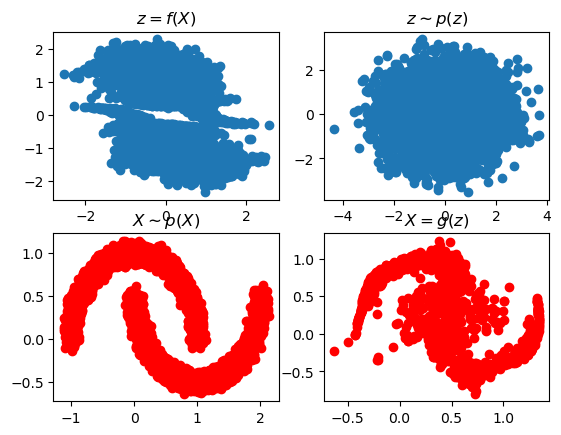

In [170]:
# TODO: Generate and visualize samples
noisy_moons = make_moons(n_samples=10000, noise=.05)[0].astype(np.float32)
z = flow.forward(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 10000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = make_moons(n_samples=10000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X = g(z)$')

Visualize the evolution of the Normalizing Flows model.

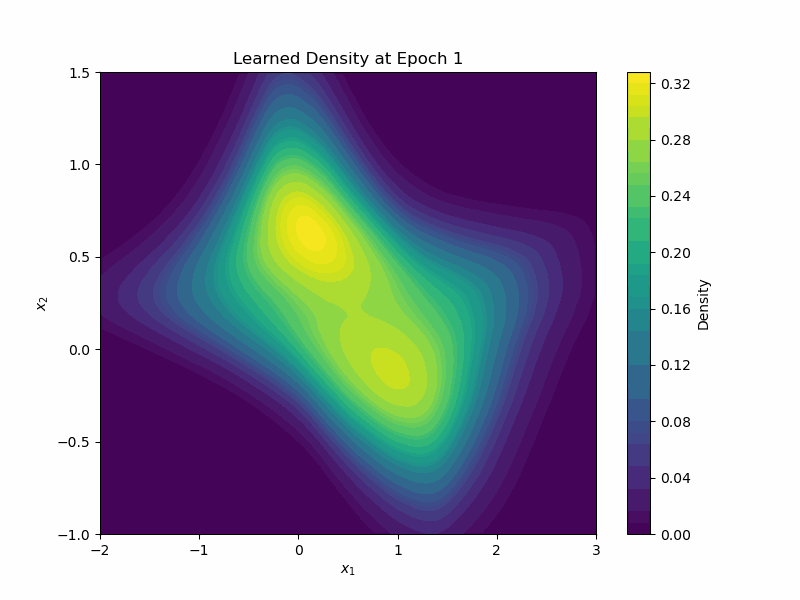

In [172]:
gif_path = create_gif()